This project uses the **ner_dataset**. Load it using pandas. 
The data can have NaN (null) values. These are removed by replacing them with the previous value in the same column of the dataframe using `fillna` method

In [ ]:
!pip install seqeval==0.0.5
!pip install keras==2.2.4
!git clone https://www.github.com/keras-team/keras-contrib.git
!cd keras-contrib
!pip install tensorflow==1.14.0

fatal: destination path 'keras-contrib' already exists and is not an empty directory.


Add all the necessary imports

In [ ]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

from keras_contrib.utils import save_load_utils

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [ ]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


Find the total no: of words and tags in the dataset

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

The data set is of the form:<br>
Sentence X -> Word 1 -> POS1 -> Tag1<br>
Sentence X -> Word 2 -> POS2 -> Tag2<br>
Sentence X -> Word 3 -> POS3 -> Tag3<br>
.<br>
.<br>
Sentence X+1 -> Word 1 -> POS1 -> Tag1

This is converted to:<br>
Sentence X -> [(Word1, POS1, Tag1), (Word2, POS2, Tag2), (Word3, POS3, Tag3) . . . . ]]<br>
Sentence X+1 -> [(Word1, POS1, Tag1), (Word2, POS2, Tag2), (Word3, POS3, Tag3) . . . . ]]<br>
.<br>
.<br>

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    #This gets the next grouped sentence i.e allows you to get sentences one by one
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [ ]:
sentences = getter.sentences

Assign numerical label to individual words and tags. This is creating a dictionary of words to their corresponding position (index + 1) in the list.

In [ ]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx["Obama"]


7238

In [ ]:
tag2idx

{'B-art': 9,
 'B-eve': 12,
 'B-geo': 0,
 'B-gpe': 6,
 'B-nat': 7,
 'B-org': 2,
 'B-per': 5,
 'B-tim': 11,
 'I-art': 15,
 'I-eve': 1,
 'I-geo': 16,
 'I-gpe': 3,
 'I-nat': 13,
 'I-org': 10,
 'I-per': 14,
 'I-tim': 8,
 'O': 4}

In [ ]:
tag2idx["B-geo"]


0

In [ ]:
n_words

35179

Now we map the sentences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the `mask_zero` parameter of the embedding layer to ignore inputs with value zero.

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [ ]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Perform one-hot encoding on the labels to convert the numerical value into vectors. `to_categorical` from the *Keras* library is used for this purpose. For eg, val=1 is represented as [1 0 0 0 .... 0] (number of places = total number of classes) and val = 2 as [0 1 0 0 0 ... 0] and so on



In [ ]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

Split the dataset into train and test random subset with a test_size of 10%. This is done with the `train_test_split` function in the *sklearn* library

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

A Tensorflow model is built with Bidiectional LSTM and CRF layers:<br>
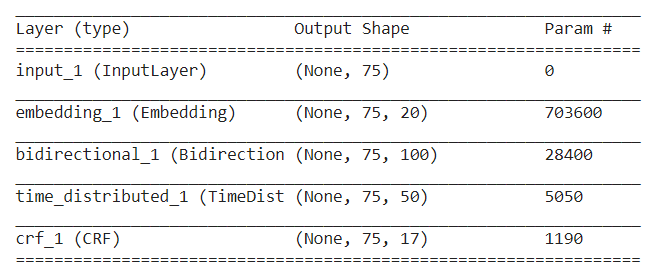 <br>

The model uses Bidirectional LSTM with CRF(Conditional Random Fields) to understand and pedict the tag of a given word based on its context. <br>
Bidirectional LSTM: A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).
<br><br>
Optimizer: It decides how to minimize the loss calculated by the Lososs Function by adjusting the weights and biases of the model Here, **RmsProp** optimizer is being used<br>

Loss Function: It calculates the difference between the xpected and actual result in each epoch. Here **CRF Loss** function is used<br>

Metric: This is used to display the history of the raining process. It tells how the model improves or impairs.




In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


The model is fit(trained) on the training dataset we made earlier. 

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 225s 6ms/step - loss: 8.9702 - crf_viterbi_accuracy: 0.9110 - val_loss: 8.7656 - val_crf_viterbi_accuracy: 0.9513
Epoch 2/5
38846/38846 [==============================] - 237s 6ms/step - loss: 8.7065 - crf_viterbi_accuracy: 0.9589 - val_loss: 8.7167 - val_crf_viterbi_accuracy: 0.9616
Epoch 3/5
38846/38846 [==============================] - 231s 6ms/step - loss: 8.6738 - crf_viterbi_accuracy: 0.9664 - val_loss: 8.7001 - val_crf_viterbi_accuracy: 0.9646
Epoch 4/5
38846/38846 [==============================] - 223s 6ms/step - loss: 8.6598 - crf_viterbi_accuracy: 0.9696 - val_loss: 8.6916 - val_crf_viterbi_accuracy: 0.9667
Epoch 5/5
38846/38846 [==============================] - 221s 6ms/step - loss: 8.6518 - crf_viterbi_accuracy: 0.9720 - val_loss: 8.6903 - val_crf_viterbi_accuracy: 0.9659


Use the trained model to predict the tags of sentences in the test dataset

In [ ]:
test_pred = model.predict(X_te, verbose=1)

Try out the model on a single sentence fom the test dataset. The output from the model are the numerical labels that we converted the input into before. So as these labels are the indices of the actual list of words and tags, it is used to display the words and their corresponding tags by getting the right element from the lists

In [ ]:
#print(classification_report(test_labels, pred_labels))
i = 1928
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred")) # Create a table form with the pipe symbol (|)
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

In [ ]:
def predict(sent):
  import re
  if (type(sent) == str):
    test_sentence = re.sub("[^\w]", " ", sent).split()
  else:
    test_sentence = sent
    
  x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

  p = model.predict(np.array([x_test_sent[0]]))
  p = np.argmax(p, axis=-1)
  l = []
  for w, pred in zip(test_sentence, p[0]):
      if (tags[pred] != 'O'):
        l.append(w)
  return l

In [ ]:
sentence= """Janice was a Fellow of the Royal Society, a lifetime member of the 
Pontifical Academy of Sciences, and a recipient of the Presidential Medal of Freedom, 
the highest civilian award in the United States. """
predict(sentence)

['Janice',
 'Royal',
 'Society',
 'Pontifical',
 'Academy',
 'of',
 'Sciences',
 'Medal',
 'United',
 'States']

Save the model in *.h5* format so that it'll be available for later use

In [ ]:
filename = "model1"
save_load_utils.save_all_weights(model,filename)

In [ ]:
save_load_utils.load_all_weights(model,"model1")

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall
save_load_utils.load_all_weights(model,"model1")

In [ ]:
# Importing all required libraries for this task.
import nltk
import keras
nltk.download('punkt')
from nltk.util import ngrams
from nltk.metrics.distance import edit_distance
from nltk.corpus import words
from nltk.tokenize import RegexpTokenizer
from itertools import chain
import json
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import *
from nltk.corpus import wordnet as wn
import time
from tqdm import tqdm
from difflib import SequenceMatcher
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Preprocessing the data

In [ ]:
def preprocessing():
    """Loading the data from 'holbrook.txt' and passing to parsing function to get parssed sentences. 
    Returning the whole dictionary as data."""
    data = []
    
    # Reading the txt file
    text_file = open("./holbrook.txt")
    lines = []
    for i in text_file:
        lines.append(i.strip())
    
    # Word tokenizing the sentences
    sentences = [nltk.word_tokenize(sent) for sent in lines]
    
    # Calling a parse function to get corrected, original sentences.
    for sent in sentences:
        data.append(parsing(sent))
    
    return data

#Calling preprocessing function
data = preprocessing()

# Testing
print(data[2])
assert(data[2] == {
 'original': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter', '.'],
 'corrected': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister', '.'],
 'indexes': [9]
})

# Splitting the data to test 100 lines and remaining training lines
test = data[:100]
train = data[100:]

{'original': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter', '.'], 'corrected': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister', '.'], 'indexes': [9]}


# Parsing the data

In [ ]:
def parsing(sent):  
    """Parsing the sentence to corrected and original and storing in the dictionary."""
    loriginal = []
    lcorrected = []
    indexes = []
    cnt = 0
    
    for i in sent:
        if '|' in i:
            # Splitting the sentence on '|'
            str1 = i.split('|')
            # Previous word to '|' is storing in loriginal list.
            loriginal.append(str1[0])
            # Next word to '|' is storing in lcorrected list.
            lcorrected.append(str1[1])
            #Noting down the index of error.
            indexes.append(cnt)
        
        else:
            # If there is no '|' in sentence, sentence is stored in loriginal and lcorrected as it is.
            loriginal.append(i)
            lcorrected.append(i)
        cnt = cnt+1
        
    #Loading to loriginal, lcorrected and index list to dictionary.      
    dictionary = {'original': loriginal, 'corrected': lcorrected, 'indexes': indexes}
    
    return dictionary

#Splitting into train and test set

In [ ]:
# Splitting the data to test - first 100 lines and remaining training lines
def test_train_split():
    """Splitting the data to test - first 100 lines and remaining training lines."""
    test = data[:100]
    train = data[100:]
    
    # Seperating the train original, test original, test corrected and train corrected from dictionary to list.
    train_corrected = [elem['corrected'] for elem in train]
    tokenizer = RegexpTokenizer(r'\w+')
    test_corrected = [elem['corrected'] for elem in test]
    test_original = [elem['original'] for elem in test]
    
    # Removing all special characters from the list.
    test_original = [tokenizer.tokenize(" ".join(elem)) for elem in test_original]
    test_corrected = [tokenizer.tokenize(" ".join(elem)) for elem in test_corrected]
    train_corrected = [tokenizer.tokenize(" ".join(elem)) for elem in train_corrected]
    
    return test_corrected, test_original, train_corrected

# Test and Training data.
test_corrected, test_original, train_corrected = test_train_split()

# Importing Edit Distance function from nltk

In [ ]:
from nltk.metrics.distance import edit_distance

# Edit distance returns the number of changes to transform one word to another
print(edit_distance("hello", "hi"))

4


# Getting candidates for replacing a misspelled word

In [ ]:
def get_candidates(token):
    
    """Get nearest word for a given incorrect word."""
    doc = []

    for i in train_corrected:
        doc.append(" ".join(i))

    doc = " ".join(doc)
    doc = nltk.word_tokenize(doc)
    unig_freq = nltk.FreqDist(doc)
    unique_words = list(unig_freq.keys())

    # Calculate distance between two words
    s = []
    for i in unique_words:
        t = edit_distance(i, token)
        s.append(t)
    
    # Store the nearest words in ordered dictionary
    dist = dict(zip(unique_words, s))
    dist_sorted = dict(sorted(dist.items(), key=lambda x:x[1]))
    minimal_dist = list(dist_sorted.values())[0]
    
    keys_min = list(filter(lambda k: dist_sorted[k] == minimal_dist, dist_sorted.keys()))
    
    return keys_min

print(get_candidates("minde"))

['mine', 'mind']


In [ ]:
# This is to culculate unigram and bigram probabilities in correct function
doc = []

for i in train_corrected:
    doc.append(" ".join(i).lower())

doc = " ".join(doc)
doc = nltk.word_tokenize(doc)
unig_freq = nltk.FreqDist(doc)
unique_words = list(unig_freq.keys())

cf_biag = nltk.ConditionalFreqDist(nltk.bigrams(doc))
cf_biag = nltk.ConditionalProbDist(cf_biag, nltk.MLEProbDist)

VBG = Verb Gerund (V-ing) <br>
VBD = Verb Past Tense (V-ed) <br>
VBN = Verb Past Participle (V-ed) <br>

In [ ]:
def tense(suggestion, sentence):    
    """Tense Detection"""
    tag = dict(nltk.pos_tag(sentence)).values()
    past_tense = ['VBN', 'VBD']
    conti_tense = ['VBG']
    
    # If sentence is past tense append ed and check if it is valid word
    if any(x in tag for x in past_tense):
        sug = []
        for a in suggestion:
            if a.lower()+'ed' in unique_words:
                sug.append(a+'ed')
        for aelem in sug:
            suggestion.append(aelem)
            
    # If sentence is continuous tense append ing and check if it is valid word
    if any(x in tag for x in conti_tense):
        sug = []
        for b in suggestion:
            if b.lower()+'ing' in unique_words:
                sug.append(b+'ing')
        for belem in sug:
            suggestion.append(belem)
        
    return suggestion 


def named_entity(sentence):
  # If any named tag like PERSON, ORGANIZATION or GEOLOCATION append to list.
  out = model.predict(sentence)
  return out

def enn(sentence):
    l = []
    for chunk in nltk.ne_chunk(nltk.pos_tag(sentence)):
        if hasattr(chunk, 'label'):
            l.append(' '.join(c[0] for c in chunk))

    
    if len(l) != 0:
        l = " ".join(l)
        l = l.split(" ")
        
    return l


def word_forms_new(suggest):
    """Taking different forms of words using derivationally related forms"""
    sug_form = []
    for w in suggest:
        forms = set()
        for i in wn.lemmas(w):
            forms.add(i.name())
            for j in i.derivationally_related_forms():
                forms.add(j.name())
        
        for a in list(forms):
            sug_form.append(a)
    
    for q in sug_form:
        suggest.append(q)
    
    word_forms = []
    [word_forms.append(i) for i in suggest if not i in word_forms]
    return word_forms


def conditions(corrected, cr_ind):
    """Common word - Oclock is not detecting. Hence handling manually but not necessary"""
    
    if 'oclock' in corrected:
        ind = corrected.index('oclock')
        corrected = list(map(lambda x: str.replace(x, "oclock", "clock"), corrected))
        corrected.insert(ind, 'o')
        return corrected
        
    return corrected

def sentence_sentence_similarity(sentence1):
    """Sentence - Sentence similarity using sequence matcher"""
    correc = []
    for d in train_corrected:
        ratio = SequenceMatcher(None, " ".join(d), " ".join(sentence1)).ratio()
        if ratio > 98:
            correc.append(d)
    
    if len(correc) == 1:
        return correc[0]
    else:
        return []


In [ ]:
" ".join("word")

'w o r d'

In [ ]:
def is_stemmed_not_in_dict(i):
  stemmer = PorterStemmer()
  return stemmer.stem(i) not in wn.words()

def is_lemmatized_not_in_dict(i):
  return lemmatizer.lemmatize(i.lower()) not in unique_words

def is_word_not_in_known_list(i, n_en, sts):
  return all([i.lower() not in source for source in [n_en, sts, wn.words()]]) 


def check_invalid(i, sts, sentence):
  n_en = enn(sentence)
  return all([is_stemmed_not_in_dict(i), is_lemmatized_not_in_dict(i), 
              is_word_not_in_known_list(i, n_en, sts), not i.isdigit()])


def perform_bigram_distr(suggestion, cnt, sentence):
  prob = []
  # Bigram probabilities
  for sug in suggestion:

      # Check the misspelled word is first or last word of the sentence
      if ((cnt != 0) and (cnt != len(sentence) - 1)):

          try:
              p1 = cf_biag[sug.lower()].prob(sentence[cnt + 1].lower())
              p2 = cf_biag[corrected[len(corrected) - 1].lower()].prob(sug.lower())
              p = p1 * p2
              prob.append(p)
          except:
              prob.append(0)

      else:
          # If mispelled word is last word of a sencence take probaility of previous word
          if cnt == len(sentence) - 1:
              try:
                  p2 = cf_biag[corrected[len(corrected) - 1].lower()].prob(sug.lower())
                  prob.append(p2)
              except:
                  prob.append(0)


          elif cnt == 0:
              # If mispelled word is first word of a sencence take probaility of next word
              try:
                  p1 = cf_biag[sug.lower()].prob(sentence[cnt + 1].lower())
                  prob.append(p1)
              except:
                  prob.append(0)

  return prob

# Main function - correct()



1.   Stemming and Lemmatizaion
2.   Sentence Sentence Similarity
3. Named Entity Recgn
4. Min Edit Distance
5. Tense Correction
6. Inclusion of alternative word forms
7. Bi gram Probability 



In [ ]:
def correct(sentence):
    sts = ['oclock']
    corrected = []
    cnt = 0
    indexes = []
    #To check stemmed word in dictonary or not
    stemmer = PorterStemmer()
    status = 0
    #This will extract all named entities of a sentence
    n_en = enn(sentence)
    
    for i in sentence:

        # Check for sentence similarity
        corr = sentence_sentence_similarity(i)
        if len(corr) == 1:
            return corr
        # Ignoring digits like page number and lemmatizing the word and check 
        # if it is present in dictionary and use words.words() for word validation.
       
        elif check_invalid(i, sts, sentence):
            indexes.append(cnt)
            if len(get_candidates(i)) > 1:
                # Get words forms, tense detection for suggested sentence
                suggestion = get_candidates(i)
                suggestion = tense(suggestion, sentence)
                wd_fms = word_forms_new(suggestion)
                suggestion = wd_fms

                prob = perform_bigram_distr(suggestion, cnt, sentence)
              
                if len(suggestion[prob.index(max(prob))]) > 1:
                    corrected.append(suggestion[prob.index(max(prob))])
                else:
                    corrected.append(suggestion[prob.index(max(prob))])

            else:
                corrected.append(get_candidates(i)[0])

        else:
            corrected.append(i)

        cnt = cnt+1
        # Manula hadling 'Oclock'
        corrected = conditions(corrected, indexes)
    
    fin = sentence_sentence_similarity(corrected)
    if len(fin) != 0:
        return fin
    else:
        return corrected



correct(['test', 'of', 'goe', 'out', 'some_times'])

['test', 'of', 'go', 'out', 'sometimes']

# Evaluate the Model

In [ ]:
start_time = time.time()
def accuracy(actual_sent, sent_pred):
    """This is based on word to word accuracy calculation. 
    Compares each word with the actual word and calculate accuracy"""
    actual = actual_sent
    predict = correct(sent_pred)
    # If the blank sentence i.e for a blank line predicted
    # is also blank take accuracy as 1

    if len(actual) == 0 and len(predict)==0:
        accuracy = 1.0
    else:
        # Take all predicted words same as actual word 
        #and divide by lenght of sentence

        accuracy = len(set(predict) & set(actual))/len(set(actual))
    
    return accuracy
    
acc = []
for i in tqdm(range(len(test_corrected))):
    acc.append(accuracy(test_corrected[i], test_original[i]))

print("\nAverage Accuracy of words in each sentence: ", 
      round(sum(acc)/len(acc)*100, 4), "%")
elapsed_time = time.time() - start_time
print("Elapsed Time is: ", elapsed_time)


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


Average Accuracy of words in each sentence:  89.2142 %
Elapsed Time is:  192.83648133277893


# Testing code

In [ ]:
def test(sent):
    print("\nOriginal: " + sent)
    print("Corrected: " + ' '.join(correct(sent.split())))

test("this is goood")
test("I am the best personaaa out therre")
test("My show is amaizng")
test("look ahedd")
test("Adam is whitr in coolor")



Original: this is goood
Corrected: this is good

Original: I am the best personaaa out therre
Corrected: I am the best person out there

Original: My show is amaizng
Corrected: My show is asking

Original: look ahedd
Corrected: look ahead

Original: Adam is whitr in coolor
Corrected: Adam is white in colour


Create a function to readily do NER on a random sentence